In [1]:
# Install latest stable PyTorch and torch-geometric dependencies
!pip install --upgrade pip

# Install PyTorch
!pip install torch torchvision torchaudio

# Install torch-geometric and required dependencies
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.2+cpu.html

# Bloom Filter library
!pip install bloom-filter2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 149.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 153.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 M

In [2]:
# Download SNAP facebook_combined dataset
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz
!gunzip facebook_combined.txt.gz


--2025-07-05 10:12:42--  https://snap.stanford.edu/data/facebook_combined.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218576 (213K) [application/x-gzip]
Saving to: ‘facebook_combined.txt.gz’

facebook_combined.t 100%[===================>] 213.45K   542KB/s    in 0.4s    

2025-07-05 10:12:43 (542 KB/s) - ‘facebook_combined.txt.gz’ saved [218576/218576]



In [54]:
import pandas as pd
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

# Load edge list
edges = pd.read_csv("facebook_combined.txt", sep=" ", header=None, names=["src", "dst"])
edge_index = torch.tensor(edges.values.T, dtype=torch.long)

# Get number of nodes
num_nodes = int(max(edges.max()) + 1)

# Dummy node features (identity matrix or constant vector)
# x = torch.eye(num_nodes)  # One-hot for simplicity
degrees = torch.zeros(num_nodes)
for src, dst in edge_index.T:
    degrees[src] += 1
    degrees[dst] += 1
# x = degrees.view(-1, 1)
two_hop = torch.zeros(num_nodes)
for src, dst in edge_index.T:
    two_hop[src] += degrees[dst]
    two_hop[dst] += degrees[src]

# Combine degree and 2-hop degree
x = torch.stack([degrees, two_hop], dim=1)  # shape: [num_nodes, 2]

# Dummy labels — here using Bloom filter hashes as pseudo-classes
y = torch.zeros(num_nodes, dtype=torch.long)  # will be replaced


In [55]:
from bloom_filter2 import BloomFilter
import hashlib

def generate_bloom_label(node_id, edge_df, num_features=25):
    bf = BloomFilter(max_elements=20, error_rate=0.1)

    # Collect neighbors
    neighbors = edge_df[edge_df['src'] == node_id]['dst'].tolist() + edge_df[edge_df['dst'] == node_id]['src'].tolist()

    # Add up to num_features neighbors into Bloom filter
    for neighbor in neighbors[:num_features]:
        bf.add(str(neighbor))

    # Use string representation of the Bloom filter
    bf_str = str(bf)

    # Hash the string representation
    hash_val = hashlib.md5(bf_str.encode()).hexdigest()

    # Convert hash to class index (0–99)
    return int(hash_val, 16) % 100


In [56]:
# ✅ NEW: Use KMeans to generate labels based on node structure
from sklearn.cluster import KMeans

# x is your node feature matrix (degree + 2-hop)
# Make sure x is defined before this step

kmeans = KMeans(n_clusters=8, random_state=42)
labels = kmeans.fit_predict(x.numpy())

# Replace y with KMeans labels
y = torch.tensor(labels, dtype=torch.long)


In [57]:
from collections import Counter
print("KMeans class distribution:", Counter(y.tolist()))

KMeans class distribution: Counter({3: 2128, 0: 891, 6: 433, 4: 188, 1: 168, 2: 124, 7: 105, 5: 2})


In [58]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)
print(data)


Data(x=[4039, 2], edge_index=[2, 88234], y=[4039])


In [59]:
from sklearn.model_selection import train_test_split

idx = list(range(data.num_nodes))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.test_mask = test_mask


In [60]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
# from torch_geometric.nn import GCNConv

# class GCN(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(input_dim, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, output_dim)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         return x
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(0.5)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        # x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x



In [61]:
from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(input_dim=2, hidden_dim=64, output_dim=10).to(device)

data = data.to(device)

optimizer = Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# model.train()
# for epoch in range(1, 101):
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out, data.y)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         pred = out.argmax(dim=1)
#         acc = (pred == data.y).sum().item() / data.num_nodes
#         print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Accuracy: {acc:.4f}")
from collections import Counter
import torch

# Count class frequency
label_counts = Counter(y.tolist())

# Inverse class frequency as weight
weights = torch.tensor([1 / label_counts[i] if i in label_counts else 0 for i in range(10)], dtype=torch.float).to(device)

# Use weighted loss
criterion = torch.nn.CrossEntropyLoss(weight=weights)
loss_values = []
acc_values = []

model.train()
# for epoch in range(1, 301):
#     optimizer.zero_grad()
#     out = model(data)
#     loss = criterion(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         pred = out.argmax(dim=1)
#         train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()
#         print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Train Accuracy: {train_acc:.4f}")

for epoch in range(1, 301):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = out.argmax(dim=1)
    acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean().item()

    # Store values for plotting
    loss_values.append(loss.item())
    acc_values.append(acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Train Accuracy: {acc:.4f}")




Epoch 010 | Loss: 4200.2949 | Train Accuracy: 0.2491
Epoch 020 | Loss: 1651.6133 | Train Accuracy: 0.2145
Epoch 030 | Loss: 988.2628 | Train Accuracy: 0.4287
Epoch 040 | Loss: 762.1005 | Train Accuracy: 0.3352
Epoch 050 | Loss: 493.1275 | Train Accuracy: 0.3770
Epoch 060 | Loss: 379.9693 | Train Accuracy: 0.4082
Epoch 070 | Loss: 439.3660 | Train Accuracy: 0.4045
Epoch 080 | Loss: 311.5257 | Train Accuracy: 0.4206
Epoch 090 | Loss: 232.5274 | Train Accuracy: 0.4383
Epoch 100 | Loss: 300.7076 | Train Accuracy: 0.2903
Epoch 110 | Loss: 172.6710 | Train Accuracy: 0.4339
Epoch 120 | Loss: 136.2019 | Train Accuracy: 0.3782
Epoch 130 | Loss: 204.3302 | Train Accuracy: 0.4726
Epoch 140 | Loss: 248.3192 | Train Accuracy: 0.2625
Epoch 150 | Loss: 159.2054 | Train Accuracy: 0.4116
Epoch 160 | Loss: 131.0174 | Train Accuracy: 0.5125
Epoch 170 | Loss: 100.2140 | Train Accuracy: 0.4373
Epoch 180 | Loss: 118.3026 | Train Accuracy: 0.5611
Epoch 190 | Loss: 89.9664 | Train Accuracy: 0.4516
Epoch 200 |

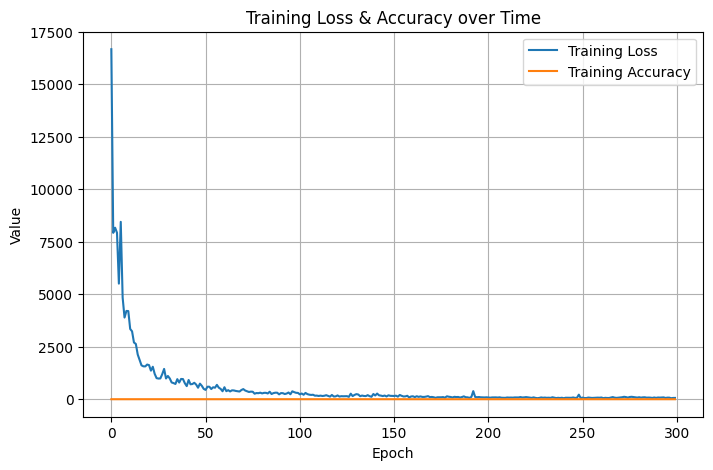

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.plot(acc_values, label='Training Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss & Accuracy over Time")
plt.legend()
plt.grid(True)
plt.show()


In [63]:
from sklearn.metrics import classification_report

# model.eval()
# out = model(data)
# pred = out.argmax(dim=1).cpu()
# true = data.y.cpu()

# print(classification_report(true, pred, zero_division=0))
model.eval()
out = model(data)
pred = out.argmax(dim=1)

test_pred = pred[data.test_mask]
test_true = data.y[data.test_mask]

from sklearn.metrics import classification_report
print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


              precision    recall  f1-score   support

           0       0.39      0.26      0.31       199
           1       0.80      0.35      0.49        34
           2       0.52      0.92      0.67        24
           3       0.84      0.69      0.76       402
           4       0.43      0.46      0.45        41
           5       0.00      0.00      0.00         0
           6       0.33      0.76      0.46        85
           7       0.34      0.65      0.45        23

    accuracy                           0.57       808
   macro avg       0.46      0.51      0.45       808
weighted avg       0.63      0.57      0.58       808



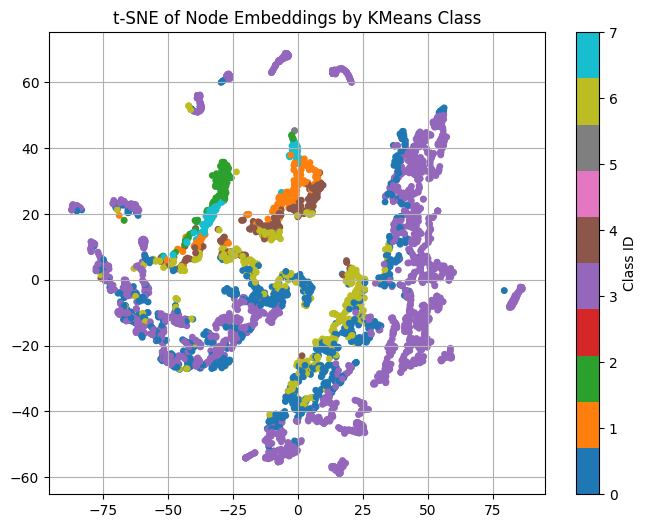

In [64]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    z = model(data).cpu().numpy()

z_2d = TSNE(n_components=2, random_state=42).fit_transform(z)

plt.figure(figsize=(8, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=data.y.cpu(), cmap='tab10', s=15)
plt.title("t-SNE of Node Embeddings by KMeans Class")
plt.colorbar(label="Class ID")
plt.grid(True)
plt.show()


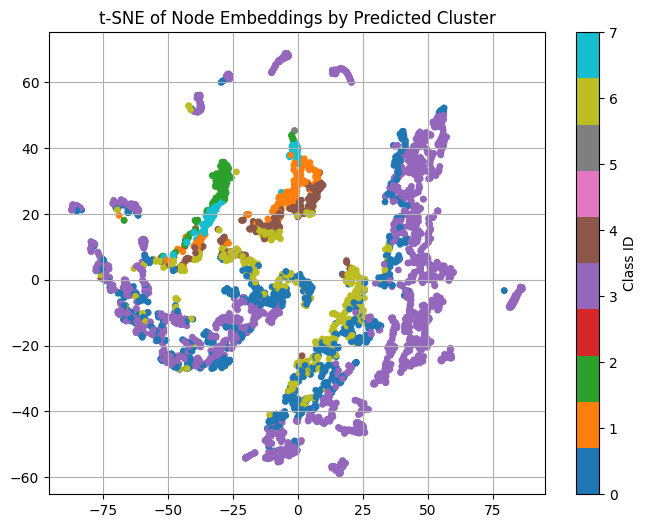

In [65]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    embeddings = model(data).cpu().numpy()

z = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap='tab10', s=15)
plt.title("t-SNE of Node Embeddings by Predicted Cluster")
plt.colorbar(label="Class ID")
plt.grid(True)
plt.show()


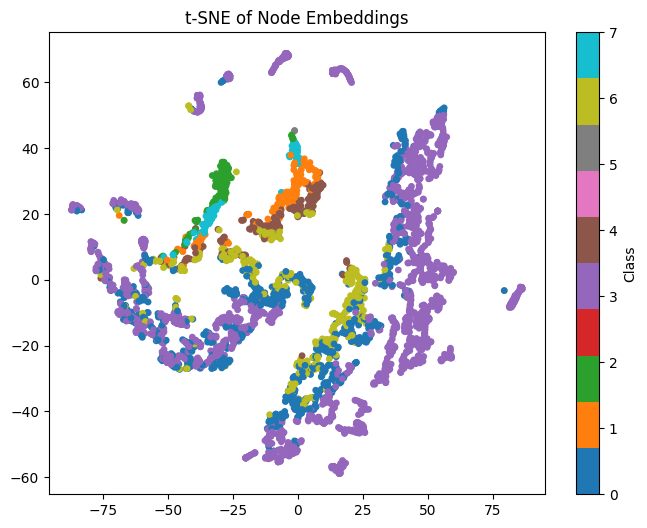

In [66]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
embeddings = model(data).detach().cpu().numpy()

z = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap='tab10', s=15)
plt.title("t-SNE of Node Embeddings")
plt.colorbar(label='Class')
plt.show()


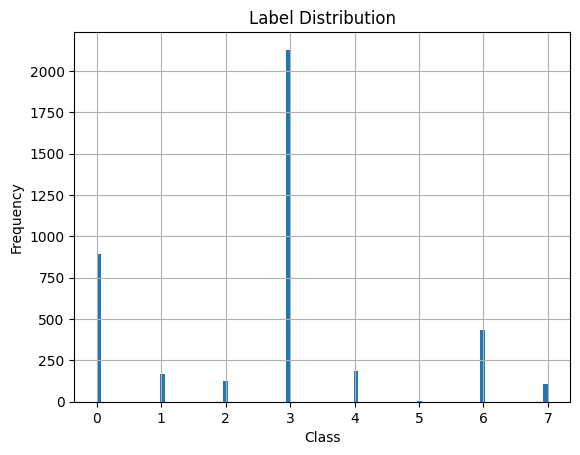

In [67]:
# import matplotlib.pyplot as plt

# plt.hist(labels, bins=100)
# plt.title("Class Distribution from Bloom Filter")
# plt.xlabel("Class Label")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()
import matplotlib.pyplot as plt

plt.hist(labels, bins=100)
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



In [68]:
from collections import Counter
Counter(labels)


Counter({np.int32(6): 433,
         np.int32(3): 2128,
         np.int32(0): 891,
         np.int32(5): 2,
         np.int32(4): 188,
         np.int32(1): 168,
         np.int32(7): 105,
         np.int32(2): 124})

In [69]:
torch.save(model.state_dict(), "graphsage_facebook_kmeans.pt")
